# <center>Centro Universitário Facens<br/></center>
<br/>
<font size="4"><center><b>Disciplina: Inteligência Artificial</b></center></font>
  
<font size="3"><center>Prof. Dr. Renato M. Silva</center></font>
<br/>

# imports de bibliotecas e de database

In [1]:
# !pip install nltk
# !pip install gensim
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install wordcloud
# !pip install tensorflow

In [2]:
import re # biblioteca para expressoes regulares
import os # biblioteca sobre o sistema operacional
import nltk # biblioteca para o preprocessamento
import gensim
from zipfile import ZipFile # biblioteca para arquivos zipados
import sklearn as skl
import numpy as np # biblioteca usada para trabalhar com vetores e matrizes
import unicodedata # sera usada para remover acentos dos documentos em lingua portuguesa
import pandas as pd # biblioteca usada para trabalhar com dataframes e análise de dados
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterGrid
from gensim.models import Word2Vec, KeyedVectors
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from collections import defaultdict




# Download bases de dados e modelo word2vec de 100 dimensões já treinado

In [3]:
url = 'https://github.com/gazzola/corpus_readability_nlp_portuguese/archive/refs/heads/master.zip'
url2 = 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s100.zip'

# especifica o local onde ficarao os arquivos
pathFiles = 'dados/'
fileName = 'corpus_readability_nlp_portuguese.zip'

# cria uma pasta onde ficarao os arquivos
if not os.path.isdir(pathFiles):
    os.mkdir(pathFiles)

# faz o download do arquivo
os.system('wget -O %s%s %s' %(pathFiles, fileName, url))
fileName2 = 'cbow_s100.zip'
os.system('wget -O %s%s %s' %(pathFiles, fileName2, url2))

print('Arquivos extraídos com sucesso!')


Arquivos extraídos com sucesso!


In [4]:
# descompacta a base de dados de notícias
z = ZipFile('dados/corpus_readability_nlp_portuguese.zip', 'r')
z.extractall('dados/')
z.close()

z = ZipFile('dados/cbow_s100.zip', 'r')
z.extractall('dados/')
z.close()

# Importação dos datasets e target

é possivel ver que os datasets não estão balanceados

In [5]:
def import_Dataset(path):

    files = os.listdir(path)

    dataset = []

    for i, file in enumerate(files):

        # abre o arquivo
        fileTexto = open(path+'/'+file, "r", encoding='utf8', errors='replace') #utf8 #cp1252

        # le o arquivo e armazena o texto dentro da variavel "texto"
        texto = fileTexto.read()

        dataset.append(texto)

    return dataset

# importa as bases de dados
dataset_Fund1 = import_Dataset('dados/corpus_readability_nlp_portuguese-master/1_Ensino_Fundamental_I')
print('Ensino Fundamental 1 importadas com sucesso, tamanho: %d' %len(dataset_Fund1))
dataset_Fund2 = import_Dataset('dados/corpus_readability_nlp_portuguese-master/2_Ensino_Fundamental_II')
print('Ensino Fundamental 2 importadas com sucesso, tamanho: %d' %len(dataset_Fund2))
dataset_Medio = import_Dataset('dados/corpus_readability_nlp_portuguese-master/3_Ensino_Medio')
print('Ensino Medio importadas com sucesso, tamanho: %d' %len(dataset_Medio))
dataset_Superior = import_Dataset('dados/corpus_readability_nlp_portuguese-master/4_Ensino_Superior')
print('Ensino Superior importadas com sucesso, tamanho: %d' %len(dataset_Superior))

# concatena as bases de dados
dataset = np.asarray( dataset_Fund1+dataset_Fund2+dataset_Medio+dataset_Superior)

# cria um vetor para cada classe
target_Fund1 = np.zeros( len(dataset_Fund1), dtype=int )
target_Fund2 = np.ones( len(dataset_Fund2), dtype=int )
target_Medio = np.full(len(dataset_Medio), 2)
target_Superior = np.full(len(dataset_Superior), 3)

# concateca os vetores de classe
target = np.concatenate((target_Fund1, target_Fund2, target_Medio, target_Superior))

# obtem as classes do problema
classes = np.unique(target)

print('\nQtd. textos dataset: %d' %len(dataset))
print('Qtd. textos target: %d' %len(target))

print(f'\nO dataset_fund1 é {round((len(dataset_Fund1) / len(dataset)) * 100, 2)}% do tamanho do dataset.')
print(f'O dataset_fund2 é {round((len(dataset_Fund2) / len(dataset)) * 100, 2)}% do tamanho do dataset.')
print(f'O dataset_medio é {round((len(dataset_Medio) / len(dataset)) * 100, 2)}% do tamanho do dataset.')
print(f'O dataset_superior é {round((len(dataset_Superior) / len(dataset)) * 100, 2)}% do tamanho do dataset.')


Ensino Fundamental 1 importadas com sucesso, tamanho: 297
Ensino Fundamental 2 importadas com sucesso, tamanho: 325
Ensino Medio importadas com sucesso, tamanho: 628
Ensino Superior importadas com sucesso, tamanho: 826

Qtd. textos dataset: 2076
Qtd. textos target: 2076

O dataset_fund1 é 14.31% do tamanho do dataset.
O dataset_fund2 é 15.66% do tamanho do dataset.
O dataset_medio é 30.25% do tamanho do dataset.
O dataset_superior é 39.79% do tamanho do dataset.


# Preprocessing

In [6]:


# Download the stopwords corpus
nltk.download('stopwords')

# Download the RSLPStemmer
nltk.download('rslp')

from nltk.stem import RSLPStemmer # para fazer a estemização em documentos da lingua portuguesa

def preprocessing_portuguese(texts, stemming = False, stopwords = False):
    preprocessed_texts = []
    for text in texts:
        # Lower case
        text = text.lower()
    
        # remove os acentos das palavras
        nfkd_form = unicodedata.normalize('NFKD', text)
        text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])
        
        # remove tags HTML
        regex = re.compile('<[^<>]+>')
        text = re.sub(regex, " ", text) 
        
        # normaliza as URLs
        regex = re.compile('(http|https)://[^\s]*')
        text = re.sub(regex, "<URL>", text)

        # normaliza emails
        regex = re.compile('[^\s]+@[^\s]+')
        text = re.sub(regex, "<EMAIL>", text)
        
        # converte todos os caracteres não-alfanuméricos em espaço
        regex = re.compile('[^A-Za-z0-9]+') 
        text = re.sub(regex, " ", text)
        
        # normaliza os numeros 
        regex = re.compile('[0-9]+.[0-9]+')
        text = re.sub(regex, "NUMERO", text)
        
        # normaliza os numeros 
        regex = re.compile('[0-9]+,[0-9]+')
        text = re.sub(regex, "NUMERO", text)
        
        # normaliza os numeros 
        regex = re.compile('[0-9]+')
        text = re.sub(regex, "NUMERO", text)

        
        # substitui varios espaçamentos seguidos em um só
        text = ' '.join(text.split())

        # separa o texto em palavras
        words = text.split() 
            
        # trunca o texto para apenas 200 termos
        words = words[0:200]

        # remove stopwords
        if stopwords:
            words = text.split() # separa o texto em palavras
            words = [w for w in words if not w in nltk.corpus.stopwords.words('portuguese')]
            text = " ".join( words )
        
        # aplica estemização
        if stemming: 
            stemmer_method = RSLPStemmer()
            words = [ stemmer_method.stem(w) for w in words ]
            text = " ".join( words )
            
        # remove palavras compostas por apenas um caracter
        words = text.split() # separa o texto em palavras
        words = [ w for w in words if len(w)>1 ]
        text = " ".join( words )
        preprocessed_texts.append(text)
    return preprocessed_texts


class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self, stemming=False, stopwords=False):
        self.stemming = stemming
        self.stopwords = stopwords

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [preprocessing_portuguese(x, self.stemming, self.stopwords) for x in X]
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


# funções para o embedding


In [13]:
import gensim
from gensim.models import Word2Vec
import torch
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads



class Embedding(BaseEstimator, TransformerMixin):
    def __init__(self, pretreinado, vector_size, window, min_count ):
        self.pretreinado = pretreinado
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        if self.pretreinado == 'Bert':
            self.model = AutoModelForPreTraining.from_pretrained('adalbertojunior/distilbert-portuguese-cased')
            print('embedding')
        elif self.pretreinado == 'True':
            self.model = KeyedVectors.load_word2vec_format('dados/cbow_s100.txt')
        else:
            self.model = Word2Vec(sentences = X,
                          vector_size = self.vector_size,
                          window = self.window,
                          min_count = self.min_count)
        return self


    def transform(self, X, y=None):
        if self.pretreinado == 'Bert':
            return self.Bert(X, self.model)
        elif self.pretreinado == 'True':
            return self.dataset2featureMatrix2(X, self.model)
        else:
            return self.dataset2featureMatrix(X, self.model)
    
    def Bert(self, dataset, model):
        
        self.tokenizer = AutoTokenizer.from_pretrained('adalbertojunior/distilbert-portuguese-cased', do_lower_case=False)
        
        X_embedding = []
        for doc in dataset:
            vec = self.GetDocVectorBert(model, doc, 100)
            X_embedding.append(vec)

        X_embedding = np.array(X_embedding)
        print(X_embedding.shape)

        return X_embedding

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def GetDocVectorBert(self, model, doc, maxLength = 100):
        encoded_input = self.tokenizer(doc, padding=True, truncation=True, max_length=maxLength, return_tensors='pt')
        # Compute token embeddings
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Perform pooling. In this case, mean pooling.
        sentence_embeddings = self.mean_pooling(model_output, encoded_input['attention_mask'])

        sentence_embeddings = sentence_embeddings.numpy()

        return sentence_embeddings
    
    def getDocvector(self, model, doc):

        wordList = []
        for word in doc:

            try:
                vec = model.wv[word]
                wordList.append(vec)
            except:
                pass

        if len(wordList)>0:
            vetorMedio = np.mean( wordList, axis=0 )
        else:
            vetorMedio = np.zeros( model.vector_size )

        return vetorMedio

    def dataset2featureMatrix(self, dataset, embeddingModel):


        X_embedding = []
        for doc in dataset:
            vec = self.getDocvector(embeddingModel, doc)
            X_embedding.append(vec)

        X_embedding = np.array(X_embedding)


        return X_embedding
    

    def getDocvector2(self, model, doc):
   
        wordList2 = []
        for word in doc:
            try:
                vec = model[word]
                wordList2.append(vec)
            except:
                pass
        if len(wordList2)>0:
            vetorMedio = np.mean( wordList2, axis=0 )
        else:        
            vetorMedio = np.zeros( model.vector_size )


        return vetorMedio

    def dataset2featureMatrix2(self, dataset, embeddingModel):


        word2v = []
        for doc in dataset:
            vec = self.getDocvector2(embeddingModel, doc)
            word2v.append(vec)

        word2v = np.array(word2v)


        return word2v

# nuvem de palavra do dataset

é  possivel observar que precisa do preprocessamento

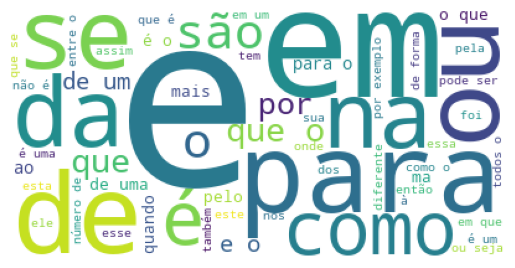

In [8]:
import matplotlib.pyplot as plt

from wordcloud import WordCloud

wc = WordCloud(min_font_size = 10, max_font_size = 200, 
               background_color = "white", relative_scaling=0.5)

# Adicione o texto à nuvem de palavras
wc.generate(" ".join(dataset))

# Plote a nuvem de palavras
plt.imshow(wc)
plt.axis("off")
plt.show()

# Divisão do dataset 


In [9]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

# Codifica os rótulos de destino em números inteiros
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# Remodela o conjunto de dados para ter duas dimensões
dataset_reshaped = np.array(dataset).reshape(-1, 1)

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(dataset_reshaped, target_encoded)

cv = skl.model_selection.StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=10)

# retorna os índices de treino e teste
train_index, test_index = list(cv.split(X_resampled, y_resampled))[0]

# retorna as partições de treino e teste de acordo com os índices
dataset2_train, dataset2_test = X_resampled[train_index], X_resampled[test_index]
Y_train, Y_test = y_resampled[train_index], y_resampled[test_index]

y_train = Y_train.astype('float32')
y_test = Y_test.astype('float32')
print('\nQtd. textos dataset: %d' %len(dataset))
print('\nQtd. textos dataset: %d' %len(dataset2_train))
print('\nQtd. textos dataset: %d' %len(dataset2_test))
print(Counter(y_resampled))


Qtd. textos dataset: 2076

Qtd. textos dataset: 950

Qtd. textos dataset: 238
Counter({0: 297, 1: 297, 2: 297, 3: 297})


# definição dos pipeline e execução do Grid Search

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dropout
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class MLP(BaseEstimator, TransformerMixin):
    def __init__(self, hidden_layer_size = [200,10], solver = 'adam', output_layer_size = 4, l2 = 0.01, dropout = 0, epochs = 50, activation = 'relu'):

        self.model = None
        self.output_layer_size = output_layer_size
        self.solver = solver
        self.hidden_layer_size = hidden_layer_size
        self.dropout = dropout
        self.epochs = epochs
        self.l2 = l2
        self.activation = activation
        # # regularizacao
        self.regularizacao = tf.keras.regularizers.L2(self.l2)
        # # Configura o modelo de rede neural artificial
        self.model = Sequential()

    def fit(self, X, y):
        self.input_layer_size  = X.shape[1]
        self.input_shape = (self.input_layer_size,)

        self.model.add(tf.keras.Input(shape=(self.input_layer_size,)))
        for i in self.hidden_layer_size:

            self.model.add(Dense(i,
                            activity_regularizer = self.regularizacao,
                            activation=self.activation)
                    )
        
        if (self.dropout > 0):
            self.model.add(Dropout(self.dropout))

        self.model.add(Dense(self.output_layer_size, activation='softmax'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

      
        # print(self.model.summary())  
        
        self.history = self.model.fit(X, y, epochs = self.epochs, validation_split=0.3, verbose = 0)
       
        return self.history
    

    def transform(self, X, y=None):
        return self
     
    
    def predict(self, X_test):
        pred = self.model.predict(X_test)
        self.model = Sequential()
        return pred
      
       
    def get_history(self):
        return self.history


## Com todos os parametros


Método:  MLP Word2Vec
8/8 [==============================] - 0s 1000us/step
Melhor Acurácia:  0.25210084033613445
Melhor Macro F1:  0.10067114093959731
Melhor precisão:  0.06302521008403361
Melhor revocação:  0.25
Melhor AUC:  0.5
Melhores Parâmetros:  {'preprocessing__stopwords': True, 'preprocessing__stemming': False, 'clf__hidden_layer_size': [200, 100, 50, 10], 'clf__dropout': 0.1, 'clf__activation': 'relu'}


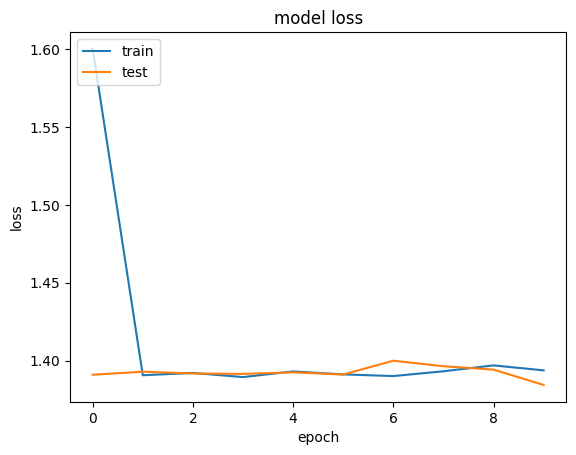


Método:  MLP Word2Vec(pretreinado)
8/8 [==============================] - 0s 1ms/step
Melhor Acurácia:  0.25210084033613445
Melhor Macro F1:  0.10067114093959731
Melhor precisão:  0.06302521008403361
Melhor revocação:  0.25
Melhor AUC:  0.5
Melhores Parâmetros:  {'preprocessing__stopwords': True, 'preprocessing__stemming': False, 'clf__hidden_layer_size': [200, 100, 50], 'clf__dropout': 0.01, 'clf__activation': 'relu'}


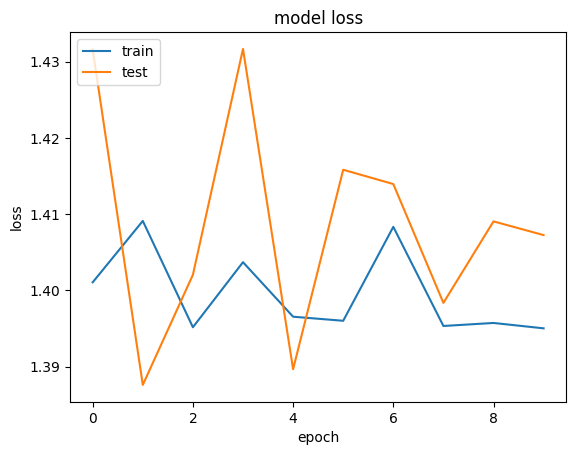


Método:  MLP Bert


Some weights of BertForPreTraining were not initialized from the model checkpoint at adalbertojunior/distilbert-portuguese-cased and are newly initialized: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


embedding
(950, 1, 29794)


ValueError: in user code:

    File "d:\Estudo\Facens\10semestre\Inteligencia Artificial\AF\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "d:\Estudo\Facens\10semestre\Inteligencia Artificial\AF\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Estudo\Facens\10semestre\Inteligencia Artificial\AF\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "d:\Estudo\Facens\10semestre\Inteligencia Artificial\AF\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "d:\Estudo\Facens\10semestre\Inteligencia Artificial\AF\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Estudo\Facens\10semestre\Inteligencia Artificial\AF\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 1, 29794)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1, 29794), dtype=float32)
      • training=True
      • mask=None


In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterSampler

pipelines = [
    
    ('MLP Word2Vec', Pipeline([
        ('preprocessing', Preprocessing()),
        ('embedding', Embedding(pretreinado=False, vector_size=200, window=3,min_count=1)),
        ('clf', MLP(epochs=10)),
    ])),
    ('MLP Word2Vec(pretreinado)', Pipeline([
        ('preprocessing', Preprocessing()),
        ('embedding', Embedding(pretreinado=True, vector_size=200, window=3,min_count=1)),
        ('clf', MLP(epochs=10)),
    ])),
     ('MLP Bert', Pipeline([
        ('preprocessing', Preprocessing()),
        ('embedding', Embedding(pretreinado='Bert', vector_size=100, window=3,min_count=1)),
        ('clf', MLP(epochs=10)),
    ])),
]

preprocessed_data = defaultdict(dict)
# Definindo a grade de parâmetros
parameters = {
    'preprocessing__stemming': [ False, True],
    'preprocessing__stopwords': [ False, True],
    'clf__hidden_layer_size':[[200,100, 50, 10], [200, 100, 50]],
    'clf__dropout':[0.01, 0.1],
    'clf__activation':['relu', 'softmax'], #camadas intermediarias, a ultima é softmax
}

param_distributions = ParameterSampler(parameters, n_iter=5)

for name, pipeline in pipelines:
    best_accuracy = 0
    best_macro = 0
    best_params = None
    best_pipeline = None
    print("\nMétodo: ", name)

    for params in param_distributions:
        # Verifica se os dados pré-processados já existem no dicionário
        key = (params['preprocessing__stemming'], params['preprocessing__stopwords'])
        
        if key in preprocessed_data:
            preprocessed_X_train = preprocessed_data[key]['train']
            preprocessed_X_test = preprocessed_data[key]['test']
        else:
            # Realiza o pré-processamento e armazena os resultados no dicionário
            preprocessor = Preprocessing(stemming=params['preprocessing__stemming'], stopwords=params['preprocessing__stopwords'])
            preprocessed_X_train = preprocessor.transform(dataset2_train)
            preprocessed_X_test = preprocessor.transform(dataset2_test)
            preprocessed_data[key]['train'] = preprocessed_X_train
            preprocessed_data[key]['test'] = preprocessed_X_test


        filtered_params_dict = {k: v for k, v in params.items() if not k.startswith('preprocessing')}
        pipeline.set_params(**filtered_params_dict)
        # Ajusta o pipeline aos dados pré-processados
        pipeline.fit(preprocessed_X_train, y_train)
        history = pipeline.named_steps['clf'].get_history()
        Y_pred = pipeline.predict(preprocessed_X_test )
        y_pred = np.argmax(Y_pred, axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro'  )
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, Y_pred, average='macro', multi_class='ovr')

        tf.keras.backend.clear_session()
        # Se o macro f1 for melhor que o melhor macro f1 até agora, atualiza o melhor macro f1 e os melhores parâmetros
        if macro_f1 > best_macro:
            best_accuracy = accuracy
            best_macro = macro_f1
            best_precision = precision
            best_recall = recall
            best_params = params
            best_pipeline = pipeline
            best_history = history
            best_auc = auc

    print("Melhor Acurácia: ", best_accuracy)
    print("Melhor Macro F1: ", best_macro)
    print("Melhor precisão: ", best_precision)
    print("Melhor revocação: ", best_recall)
    print("Melhor AUC: ", best_auc)
    print("Melhores Parâmetros: ", best_params)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

